<a href="https://colab.research.google.com/github/palles77/siidatasets/blob/main/image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [ ]:
!wget --no-check-certificate --content-disposition https://github.com/palles77/siidatasets/raw/main/catsanddogs.tar.gz

--2022-10-19 14:58:24--  https://github.com/palles77/siidatasets/raw/main/catsanddogs.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/palles77/siidatasets/main/catsanddogs.tar.gz [following]
--2022-10-19 14:58:24--  https://raw.githubusercontent.com/palles77/siidatasets/main/catsanddogs.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96846761 (92M) [application/octet-stream]
Saving to: ‘catsanddogs.tar.gz’

catsanddogs.tar.gz  100%[===================>]  92.36M   296MB/s    in 0.3s    

2022-10-19 14:58:24 (296 MB/s) - ‘catsanddogs.tar.gz’ saved [96846761/96846761]



In [ ]:
!ls -ltr
!tar -xvf catsanddogs.tar.gz

total 94580
-rw-r--r-- 1 root root 96846761 Oct 19 14:58 catsanddogs.tar.gz
PetImages/
PetImages/Cat/
PetImages/Cat/0.jpg
PetImages/Cat/1.jpg
PetImages/Cat/10.jpg
PetImages/Cat/100.jpg
PetImages/Cat/1000.jpg
PetImages/Cat/10000.jpg
PetImages/Cat/10001.jpg
PetImages/Cat/10002.jpg
PetImages/Cat/10003.jpg
PetImages/Cat/10004.jpg
PetImages/Cat/10005.jpg
PetImages/Cat/10006.jpg
PetImages/Cat/10007.jpg
PetImages/Cat/10008.jpg
PetImages/Cat/10009.jpg
PetImages/Cat/1001.jpg
PetImages/Cat/10010.jpg
PetImages/Cat/10011.jpg
PetImages/Cat/10012.jpg
PetImages/Cat/10013.jpg
PetImages/Cat/10014.jpg
PetImages/Cat/10015.jpg
PetImages/Cat/10016.jpg
PetImages/Cat/10017.jpg
PetImages/Cat/10018.jpg
PetImages/Cat/10019.jpg
PetImages/Cat/1002.jpg
PetImages/Cat/10020.jpg
PetImages/Cat/10021.jpg
PetImages/Cat/10022.jpg
PetImages/Cat/10023.jpg
PetImages/Cat/10024.jpg
PetImages/Cat/10025.jpg
PetImages/Cat/10026.jpg
PetImages/Cat/10027.jpg
PetImages/Cat/10028.jpg
PetImages/Cat/10029.jpg
PetImages/Cat/1003.jpg
Pet

Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [ ]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 178 images


## Generate a `Dataset`

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2822 files belonging to 2 classes.
Using 2258 files for training.
Found 2822 files belonging to 2 classes.
Using 564 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

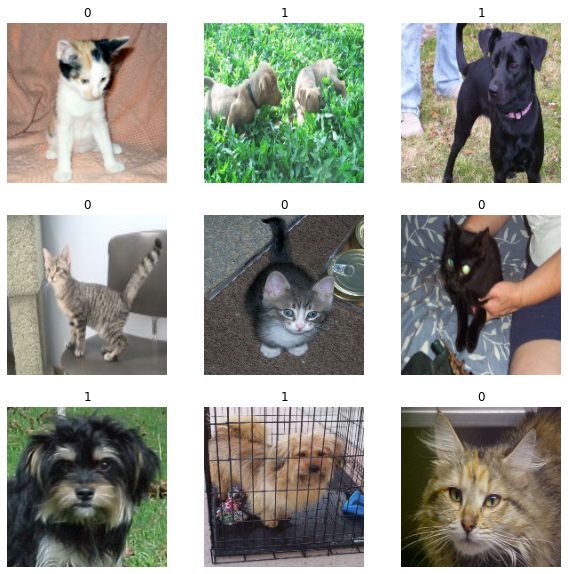

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

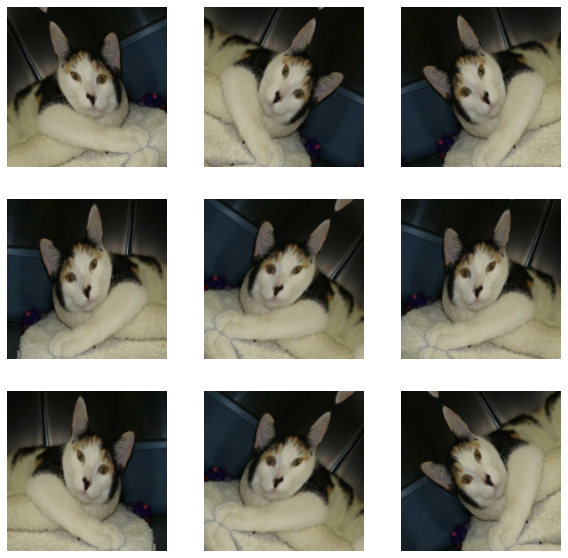

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

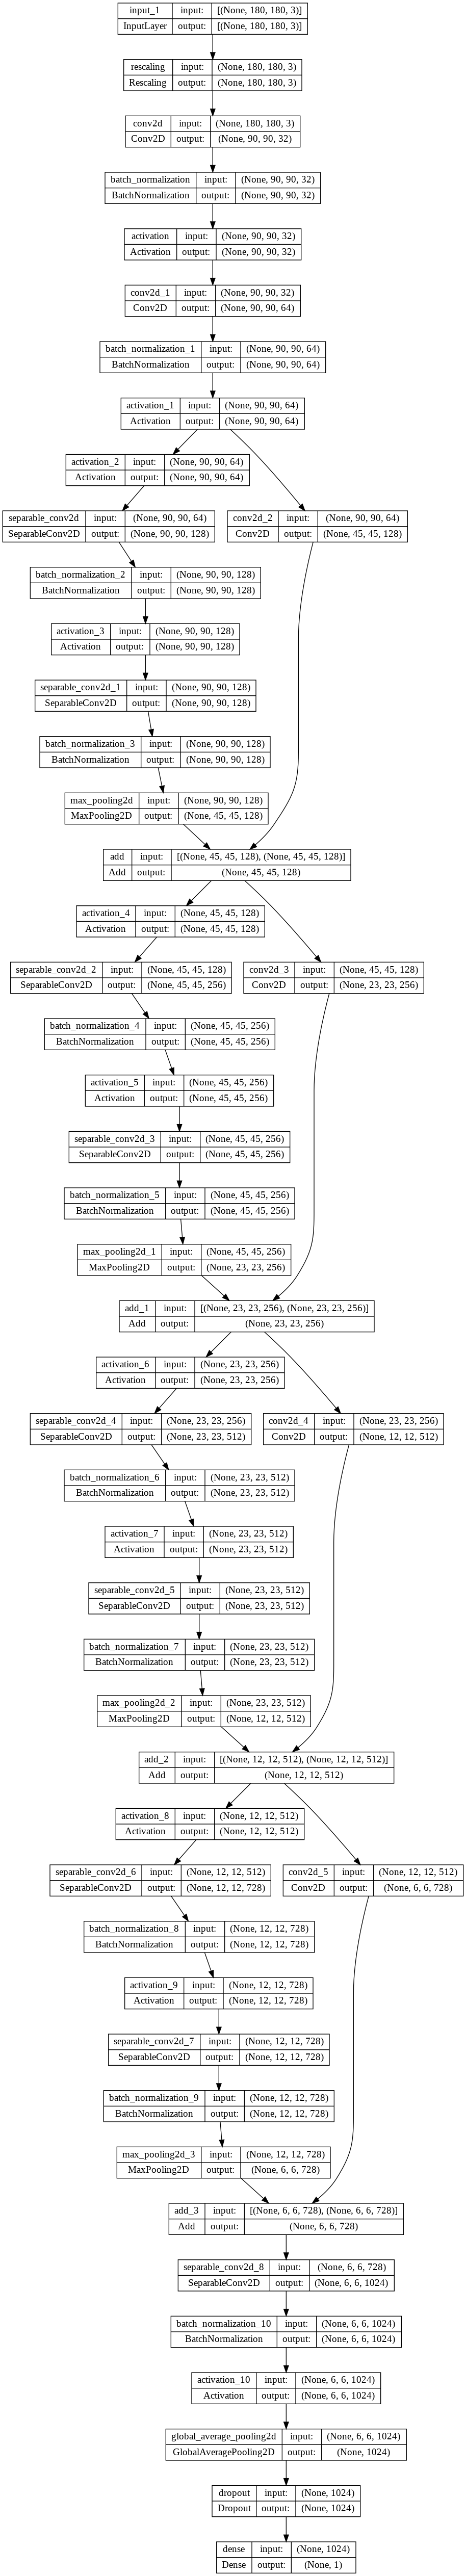

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

And let's apply data augmentation to our training dataset:

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

## Train the model

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
71/71 [==============================] - 618s 9s/step - loss: 0.7062 - accuracy: 0.6041 - val_loss: 0.7040 - val_accuracy: 0.4858
Epoch 2/50
71/71 [==============================] - 617s 9s/step - loss: 0.6236 - accuracy: 0.6727 - val_loss: 0.7790 - val_accuracy: 0.4858
Epoch 3/50
71/71 [==============================] - 613s 9s/step - loss: 0.5629 - accuracy: 0.7157 - val_loss: 0.8377 - val_accuracy: 0.4858
Epoch 4/50
71/71 [==============================] - 612s 9s/step - loss: 0.5158 - accuracy: 0.7520 - val_loss: 1.1157 - val_accuracy: 0.4858
Epoch 5/50
71/71 [==============================] - 616s 9s/step - loss: 0.4537 - accuracy: 0.7861 - val_loss: 1.3261 - val_accuracy: 0.4858
Epoch 6/50
71/71 [==============================] - 615s 9s/step - loss: 0.4148 - accuracy: 0.8082 - val_loss: 1.1058 - val_accuracy: 0.4858
Epoch 7/50
71/71 [==============================] - 615s 9s/step - loss: 0.3421 - accuracy: 0.8459 - val_loss: 0.9340 - val_accuracy: 0.4858
Epoch 8/50
71

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")